In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = k_0 \rho + k_1 (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + k_2 (I \otimes \sigma_3) \rho (I \otimes \sigma_3) . $$

with $k_0 + k_1 + k_2 = 1$. To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $k_0, k_1, k_2$. 


In [32]:
"""Function to create the circuit given the values of k:"""

def ks_to_circuit(ks):
    k0,k1,k2,k3 = ks
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1)) - np.angle(np.sqrt(k2)+1j*np.sqrt(k3))
    theta1 = 2*np.arccos(np.sqrt(k0+k1))
    theta2 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1)) + np.angle(np.sqrt(k2)+1j*np.sqrt(k3))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(4, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,2)
    circ.ry(theta0,3)
    circ.cz(2,3)
    circ.ry(theta2,3)
    
    #Add the controlled gates.
    cz = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='01')
    cx = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    cy = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='11')

    #     czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    
    
    
    circ.append(cz, [ 2,3, 0])
    circ.append(cz, [ 2,3, 1])
    circ.append(cx, [ 2,3, 0])
    circ.append(cx, [ 2,3, 1])
#     circ.append(cy, [ 2,3, 0])
#     circ.append(cy, [ 2,3, 1])

    #     circ.append(czi, [2,3, 1])

    return(circ)

circ = ks_to_circuit([0.4,0.1,0.2,0.3])
circ.draw()

┌───┐     
q_0: ──────────────────────────────────■────┤ X ├─────
                                       │    └─┬─┘┌───┐
q_1: ──────────────────────────────────┼──■───┼──┤ X ├
       ┌─────────┐                     │  │   │  └─┬─┘
q_2: ──┤ Ry(π/2) ├────■────────────────■──■───o────o──
     ┌─┴─────────┴──┐ │ ┌────────────┐ │  │   │    │  
q_3: ┤ Ry(-0.42243) ├─■─┤ Ry(1.3497) ├─o──o───■────■──
     └──────────────┘   └────────────┘

Create many instances of the channel for different values of $p_0,p_1,p_2$:

In [38]:
points = []
for k in np.arange(0,1.5,0.3):
    points.append(np.around([1-2*k/3,k/3,k/3,0],2))
points


[array([1., 0., 0., 0.]),
 array([0.8, 0.1, 0.1, 0. ]),
 array([0.6, 0.2, 0.2, 0. ]),
 array([0.4, 0.3, 0.3, 0. ]),
 array([0.2, 0.4, 0.4, 0. ])]

In [39]:

circuits = []
for k in points:
    circuits.append(ks_to_circuit(k))

circuits[2].draw()


┌───┐     
q_0: ─────────────────────────────■────┤ X ├─────
                                  │    └─┬─┘┌───┐
q_1: ─────────────────────────────┼──■───┼──┤ X ├
     ┌────────────┐               │  │   │  └─┬─┘
q_2: ┤ Ry(0.9273) ├─■─────────────■──■───o────o──
     └┬─────────┬─┘ │ ┌─────────┐ │  │   │    │  
q_3: ─┤ Ry(π/6) ├───■─┤ Ry(π/6) ├─o──o───■────■──
      └─────────┘     └─────────┘

### Run Quantum Process tomography

In [40]:
def choi_theoretical(ks):
    '''For some values of taus describing a Pauli channel, this function
    returns the choi matrix of said channel.
    
    Args:
        taus (list): The list of taus [tau1,tau2,tau3] that defines a Pauli channel.
    
    Returns:
        mat_choi (qi.choi): The choi matrix of the channel.
    '''
    
    
    #First we convert the taus to the ks that describe the channel.
    k0,k1,k2,k3 = ks
    
    #We can write the Kraus representation of the channel, using that the 
    # Kraus operators are \sqrt{k_i} \sigma_i with \sigma_i the ith Pauli matrix.
    
    k = Kraus([np.sqrt(k0)*np.kron(I,I),np.sqrt(k1)*np.kron(Z,Z),
              np.sqrt(k2)*np.kron(X,X),np.sqrt(k3)*np.kron(Y,Y)])
    
    #We convert the Kraus repre,,np.sqrt(k1)*np.kron(X,X)sentation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [41]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima

In [42]:
from qiskit.providers.fake_provider import FakeManila

In [43]:
circuits[1].draw()

┌───┐     
q_0: ──────────────────────────────────■────┤ X ├─────
                                       │    └─┬─┘┌───┐
q_1: ──────────────────────────────────┼──■───┼──┤ X ├
      ┌────────────┐                   │  │   │  └─┬─┘
q_2: ─┤ Ry(0.6435) ├─■─────────────────■──■───o────o──
     ┌┴────────────┤ │ ┌─────────────┐ │  │   │    │  
q_3: ┤ Ry(0.33984) ├─■─┤ Ry(0.33984) ├─o──o───■────■──
     └─────────────┘   └─────────────┘

In [45]:
backend = AerSimulator.from_backend(FakeManila())
# backend = Aer.get_backend('aer_simulator')

fidelities = []
for i in range(len(points)):
    print(i)
    point = points[i]
    circ = circuits[i]
    
    
    qpt = ProcessTomography(circ,backend,measurement_indices=[0,1],
                            preparation_indices=[0,1])
    qpt.set_run_options(shots=20000)
    
    qpt_run = qpt.run()
    qptdata = qpt_run.block_for_results()
    
    
    
    choi_simu = qptdata.analysis_results("state").value
    choi_theo = choi_theoretical(point)
    
    dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
    fidelities.append(1-0.5*dis)
    print(1-0.5*dis)
    

0
0.3327946663412462
1
0.35893172573300547
2
0.43334497495575963
3
0.4483228971172485
4
0.4066901125285547


In [11]:
fidelities[0]

0.9831039812929737

In [29]:
with open("pruebas/Resultados/fidelity-2qbit-xxyyzz.csv","w") as f:
    f.write("p,fid")
    
    for i in range(len(points)):
        f.write("\n" + str(points[i]) + "," + str(fidelities[i]))
        

In [30]:
fidelities =[]

import csv
import pandas as pd


data = pd.read_csv("pruebas/Resultados/fidelity-2qbit-xxyyzz.csv")

        
fidelities = data['fid']
fidelities = np.array(fidelities)

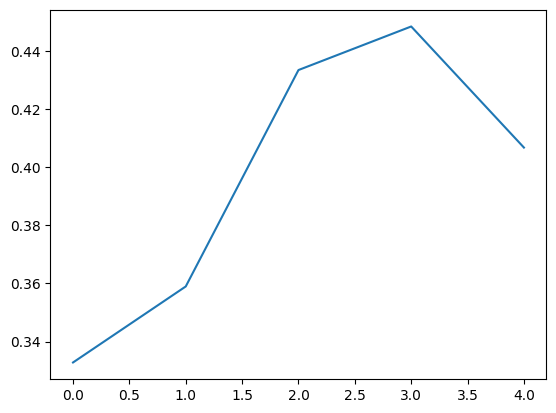

In [46]:
plt.plot(fidelities)